In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("creditcard.csv")[:80000]
print(f"head : {df.head(3)}")
print(f"size: {df.size}")
print(f"shape: {df.shape}")

head :    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]
size: 2480000
shape: (80000, 31)


In [3]:
df.keys()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.head(2)['Time']

0    0.0
1    0.0
Name: Time, dtype: float64

In [5]:
X = df.drop(columns=['Time', 'Amount', 'Class']).values
y = df['Class'].values
f"Shapes of X={X.shape} y={y.shape}, #Fraud Cases = {y.sum()}"

'Shapes of X=(80000, 28) y=(80000,), #Fraud Cases = 196'

In [6]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(class_weight={0:1,1:2}, max_iter=1000)
mod.fit(X,y).predict(X).sum().item()

172

In [7]:
from sklearn.metrics import recall_score, precision_score, make_scorer

In [8]:
def min_recall_precision(y_true, y_pred):
    recall = recall_score(y_true,y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

In [9]:
make_scorer(min_recall_precision, greater_is_better=False)

make_scorer(min_recall_precision, greater_is_better=False, response_method='predict')

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer

def min_recall_precision(est, X, y_true, sample_weight=None):
    y_pred = est.predict(X)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return min(recall, precision)

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000), 
    param_grid={'class_weight': [{0:1, 1:v} for v in np.linspace(1,20,30)]}, 
    scoring={'precision': make_scorer(precision_score), 
             'recall': make_scorer(recall_score), 
             'min_both':min_recall_precision}, 
    refit='min_both', 
    return_train_score=True, 
    cv=10, 
    n_jobs=-1
)
grid.fit(X,y)

/home/osboxes/anaconda3/envs/scikit/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/osboxes/anaconda3/envs/scikit/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: np.float64(1.0)},
                                          {0: 1,
                                           1: np.float64(1.6551724137931034)},
                                          {0: 1,
                                           1: np.float64(2.310344827586207)},
                                          {0: 1,
                                           1: np.float64(2.9655172413793105)},
                                          {0: 1,
                                           1: np.float64(3.6206896551724137)},
                                          {0: 1,
                                           1: np.float64(4.275862068965517)},
                                          {0: 1,
                                           1: np.float64(4.931034482758...
                                           1: np.float64(18.03448275862069)},
                                          {0: 1,
                                           1: np.float64(18.689655172413794)},
                                          {0: 1,
                                           1: np.float64(19.344827586206897)},
                                          {0: 1, 1: np.float64(20.0)}]},
             refit='min_both', return_train_score=True,
             scoring={'min_both': <function min_recall_precision at 0x700ab19e1ee0>,
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

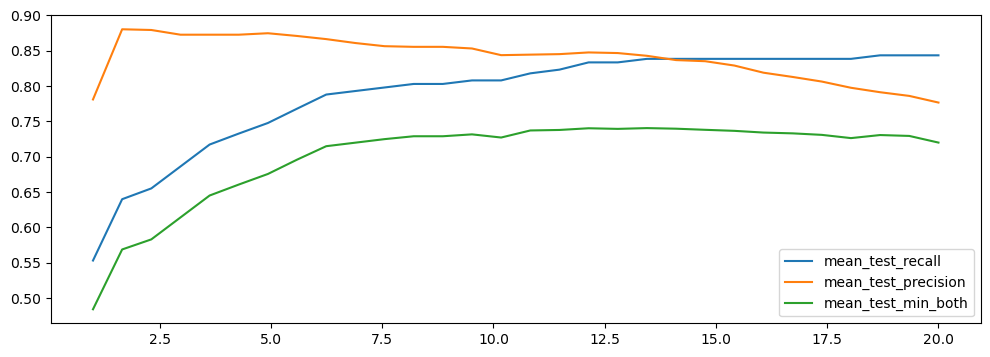

In [11]:
plt.figure(figsize=(12,4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall','mean_test_precision','mean_test_min_both']:
    plt.plot([_[1] for _ in df_results['param_class_weight']], 
             df_results[score], 
             label=score)
plt.legend()

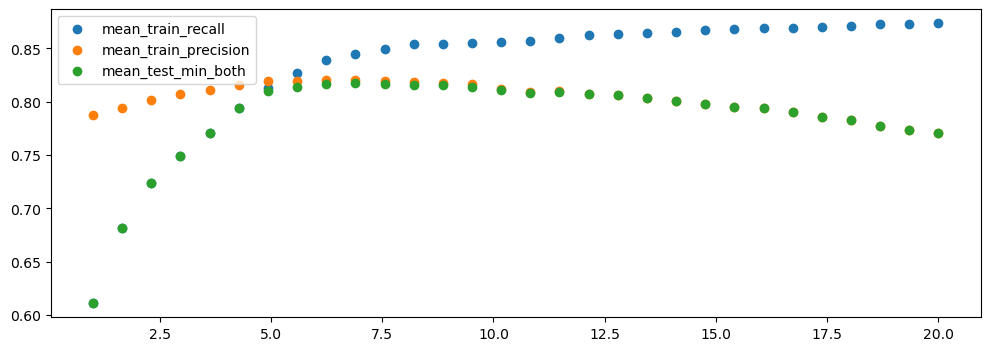

In [12]:
plt.figure(figsize=(12, 4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_train_recall', 'mean_train_precision', 'mean_test_min_both']:
    plt.scatter(x=[_[1] for _ in df_results['param_class_weight']], 
                y=df_results[score.replace('test', 'train')], 
                label=score)
plt.legend();

In [13]:
from collections import Counter
from sklearn.ensemble import IsolationForest
mod = IsolationForest().fit(X)
np.where(mod.predict(X) == -1, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

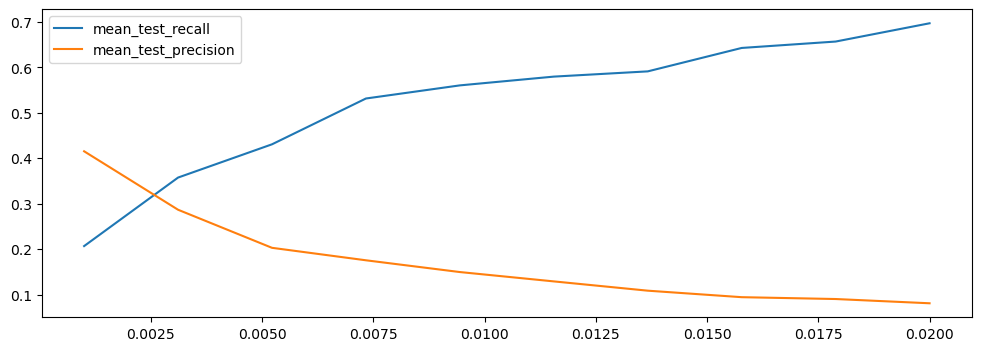

In [25]:
def outlier_precision(mod,X,y):
    preds = mod.predict(X)
    return precision_score(y,np.where(preds == -1, 1,0))

def outlier_recall(mod,X,y):
    preds = mod.predict(X)
    return recall_score(y,np.where(preds == -1, 1,0))

grid = GridSearchCV(
    estimator=IsolationForest(), 
    param_grid={'contamination': np.linspace(0.001, 0.02, 10)}, 
    scoring={'precision': outlier_precision, 
             'recall': outlier_recall}, 
    refit='precision', 
    cv=5, 
    n_jobs=-1
)
grid.fit(X,y)

plt.figure(figsize=(12,4))
df_results = pd.DataFrame(grid.cv_results_)
for score in ['mean_test_recall', 'mean_test_precision']:
    plt.plot(df_results['param_contamination'], 
             df_results[score], 
             label=score)
plt.legend()

In [28]:
df_results.keys().size

22

In [32]:
df = pd.DataFrame(grid.cv_results_)
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_recall'])
plt.plot([_[1] for _ in df['param_class_weight']], df['mean_test_precision'])

KeyError: 'param_class_weight'